In [1]:
import time
from cflib.crazyflie.swarm import CachedCfFactory
from cflib.crazyflie.swarm import Swarm
from scipy.spatial.transform import Rotation
import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.utils import uri_helper
from cflib.utils.reset_estimator import reset_estimator
import os

# Perform varioous operations on the Crazyflie drones in a swarm
# such as taking off, landing, hovering, and running square sequences.

In [ ]:
#### Take off and land functions ####
def take_off(scf):
    commander= scf.cf.high_level_commander
    commander.stop()
    time.sleep(1.5)  # Ensure the commander is stopped before taking off
    commander.takeoff(1.25, 3.0)
    time.sleep(3)

def land(scf):
    commander= scf.cf.high_level_commander

    commander.land(0.15, 5.0)
    time.sleep(4)

    commander.stop()

####################################

In [3]:
def send_setpoint(cf, duration, pos):
    # Set points must be sent continuously to the Crazyflie, if not it will think that connection is lost
    end_time = time.time() + duration
    while time.time() < end_time:
        cf.commander.send_position_setpoint(*pos)
        time.sleep(0.1)

def go_to_initial_position(scf, pos):
    cf = scf.cf
    send_setpoint(cf, 4.0, pos)
    time.sleep(1)

def run_square_sequence(scf, drone_index, initial_pos):
    cf = scf.cf
    num_drones = len(initial_pos)
    home_pos = initial_pos[drone_index]

    for loop in range(2):  # Repeat the square twice
        # Only go to home_pos at the start of the first loop
        if loop == 0:
            send_setpoint(cf, 5.0, home_pos)
            time.sleep(0.1)
        # Visit all other positions in order
        for step in range(1, num_drones):
            next_index = (drone_index + step) % num_drones
            next_pos = initial_pos[next_index]
            send_setpoint(cf, 5.0, next_pos)
            time.sleep(0.1)
        # Return to own initial position to close the square
        send_setpoint(cf, 5.0, home_pos)
        time.sleep(0.1)

    smooth_landing(scf, home_pos)

def smooth_landing(scf, pos):
    cf = scf.cf
    # Keep XY and yaw, set Z to 0.3
    landing_pos0 = [pos[0], pos[1], 1.0, pos[3]]
    landing_pos1 = [pos[0], pos[1], 0.5, pos[3]]
    print(f"Drone smooth landing to {landing_pos0}")
    send_setpoint(cf, 3.0, landing_pos0)
    send_setpoint(cf, 1.0, landing_pos1)
    land(scf)


In [4]:
def go_to_initial_position_high_level(scf, pos):
    hlc = scf.cf.high_level_commander
    hlc.go_to(*pos, 0, 3.0, relative=False)
    time.sleep(4.0)

# def run_square_sequence_high_level(scf, drone_index, initial_pos):
#     hlc = scf.cf.high_level_commander
#     num_drones = len(initial_pos)
#     home_pos = initial_pos[drone_index]

#     for loop in range(2):  # Repeat the square twice
#         # Only go to home_pos at the start of the first loop
#         if loop == 0:
#             hlc.go_to(*home_pos, 0, 3.0, relative=False)
#             time.sleep(5.0)
#         # Visit all other positions in order
#         for step in range(1, num_drones):
#             next_index = (drone_index + step) % num_drones
#             next_pos = initial_pos[next_index]
#             hlc.go_to(*next_pos, 0, 2.5, relative=False)
#             time.sleep(5.0)
#         # Return to own initial position to close the square
#         hlc.go_to(*home_pos, 0, 2.5, relative=False)
#         time.sleep(5.0)

def run_square_sequence_high_level(scf, drone_index, initial_pos):
    hlc = scf.cf.high_level_commander
    # Only use first 4 positions for square motion
    square_positions = initial_pos[:4]
    num_square_drones = len(square_positions)
    home_pos = initial_pos[drone_index]

    if drone_index == 4 or drone_index == 5 or drone_index==6:  # 5th drone (index starts from 0)
        print(f"Drone {drone_index+1} hovering at {home_pos}")
        hlc.go_to(*home_pos, 0, 6.0, relative=False)
        time.sleep(6.0)
    else:
        for loop in range(2):  # Repeat the square twice
            if loop == 0:
                hlc.go_to(*home_pos, 0, 3.0, relative=False)
                time.sleep(5.0)
            for step in range(1, num_square_drones):
                next_index = (drone_index + step) % num_square_drones
                next_pos = square_positions[next_index]
                hlc.go_to(*next_pos, 0, 2.0, relative=False)
                time.sleep(5.0)
            hlc.go_to(*home_pos, 0, 2.0, relative=False)
            time.sleep(5.0)
            

def smooth_landing_high_level(scf, pos):
    hlc = scf.cf.high_level_commander
    # Keep XY and yaw, set Z to 0.3
    landing_pos0 = [pos[0], pos[1], 0.5]
    landing_pos1 = [pos[0], pos[1], 0.25]
    print(f"Drone smooth landing to {landing_pos0}")
    hlc.go_to(*landing_pos0, 0, 3.0, relative=False)
    time.sleep(2.0)
    hlc.go_to(*landing_pos1, 0, 2.0, relative=False)
    time.sleep(1.0)
    hlc.land(0.0, 1.0)

def position_callback_factory(filename):
    def position_callback(timestamp, data, logconf):
        x = data['kalman.stateX']
        y = data['kalman.stateY']
        z = data['kalman.stateZ']
        with open(filename, 'a') as f:
            f.write('{},{},{},{}\n'.format(timestamp, x, y, z))
    return position_callback

def start_position_printing(scf, filename):
    log_conf = LogConfig(name='Position', period_in_ms=100)
    log_conf.add_variable('kalman.stateX', 'float')
    log_conf.add_variable('kalman.stateY', 'float')
    log_conf.add_variable('kalman.stateZ', 'float')
    scf.cf.log.add_config(log_conf)
    log_conf.data_received_cb.add_callback(position_callback_factory(filename))
    log_conf.start()
    return log_conf

def stop_position_printing(log_conf):
    if log_conf is not None:
        log_conf.stop()

In [ ]:
uris = [
    'radio://0/20/2M/E7E7E7E705',
    'radio://1/60/2M/E7E7E7E706',
    'radio://1/60/2M/E7E7E7E707',
    'radio://1/60/2M/E7E7E7E708',
    # ^Square motion drones
    'radio://0/20/2M/E7E7E7E704',
    'radio://2/40/2M/E7E7E7E701',
    'radio://0/20/2M/E7E7E7E703',
    # ^Center Drones
]

initial_pos = [
    [0.75, 0.75, 1.25],  # Drone 1
    [3.75, 0.75, 1.25],  # Drone 2
    [3.75, 3.75, 1.25],  # Drone 3
    [0.75, 3.75, 1.25],  # Drone 4

    [2.0, 1.5, 1.25],  # Drone 5
    [2.0, 3.0, 1.25],  # Drone 6

    [2.0, 2.25, 1.25],  # Drone 7
]


# landing_pos = [
#     [0.75, 0.75, 1.25],  # Drone 1
#     [3.75, 0.75, 1.25],  # Drone 2
#     [3.75, 3.75, 1.25],  # Drone 3
#     [0.75, 3.75, 1.25],  # Drone 4

#     [2.0, 1.5, 1.25],  # Drone 5
#     [2.0, 3.0, 1.25],  # Drone 6

#     [2.0, 2.25, 1.25],  # Drone 7
# ]


landing_pos = [
    [1.5, 1.5, 1.25],  # Drone 1 
    [2.5, 1.5, 1.25],  # Drone 2
    [2.5, 2.5, 1.25],  # Drone 3
    [1.5, 2.5, 1.25],  # Drone 4

    [2.0, 1.5, 1.25],  # Drone 5
    [2.0, 3.0, 1.25],  # Drone 6

    [2.0, 2.25, 1.25],  # Drone 7
]


initial_pos_set = [
    [1.0, 1.0, 1.25, 0.0],  # Drone 1
    [3.0, 1.0, 1.25, 0.0],  # Drone 2
    [3.0, 3.0, 1.25, 0.0],  # Drone 3
    [1.0, 3.0, 1.25, 0.0],  # Drone 4
]

# Low level setpoint motion
low_level = False

In [6]:
def robust_kalman(scf):
    uri = scf.cf.link_uri
    print(f"Setting robust kalman filter for {uri}...")
    scf.cf.param.set_value('kalman.robustTdoa', 1)
    time.sleep(0.5)  # wait for the parameter to be applied
    # Read the parameter to confirm it's set
    value = scf.cf.param.get_value('kalman.robustTdoa')
    if str(value) == '1':
        print(f"Robust kalman filter confirmed as set for {uri}.")
    else:
        print(f"Robust kalman filter not confirmed for {uri}, got value: {value}")

def wait_for_param_download(scf):
    while not scf.cf.param.is_updated:
        time.sleep(1.0)
    print('Parameters downloaded for', scf.cf.link_uri)

In [ ]:
cflib.crtp.init_drivers()
factory = CachedCfFactory(rw_cache='./cache')
with Swarm(uris, factory=factory) as swarm:
    
    for uri in uris:
        if os.path.exists(f"C:/Users/omerr/drone-swarm/data_swarm/data_{uri[-2:]}.csv"):
            os.remove(f"C:/Users/omerr/drone-swarm/data_swarm/data_{uri[-2:]}.csv")
    time.sleep(1)

    # Prepare argument dictionaries for parallel execution
    init_args = {uri: (pos,) for uri, pos in zip(uris, initial_pos)}
    land_args = {uri: (pos,) for uri, pos in zip(uris, landing_pos)}


    # Only drones 1-4 join the square motion
    # square_uris = uris[:4]
    # seq_args = {uri: (idx, initial_pos) for idx, uri in enumerate(square_uris)}
    # seq_args_set = {uri: (idx, initial_pos_set) for idx, uri in enumerate(square_uris)}
    

    seq_args = {uri: (idx, initial_pos) for idx, uri in enumerate(uris)}
    seq_args_set = {uri: (idx, initial_pos_set) for idx, uri in enumerate(uris)}

    log_args = {
    uri: (f"C:/Users/omerr/drone-swarm/data_swarm/data_{uri[-2:]}.csv",)
    for uri in uris
    }

    

    print('Connected to Crazyflies')
    print("Waiting for parameters to be downloaded on each drone…")
    swarm.parallel_safe(wait_for_param_download)
    print("All parameters downloaded, now safe to set/get params")

    print('Setting to robust kalman filter...')
    swarm.parallel_safe(robust_kalman)
    time.sleep(1.0)
    
    print('Resetting estimators...')
    swarm.reset_estimators()
    print('Done resetting estimators')
    time.sleep(3)

    try:
        print('Taking off drones...')
        print('Initiating Pearl Harbor sequence...')
        print('Happy Flying! :)')
        swarm.parallel_safe(take_off)
        time.sleep(1.5)
        
        print('Going to initial positions...')
        swarm.parallel_safe(go_to_initial_position_high_level, args_dict=init_args)
        time.sleep(1.0)
        print('Starting position logging for the drones...')
        swarm.parallel_safe(start_position_printing, args_dict=log_args)
        time.sleep(3.0)

        if low_level:

            print('Starting square sequence...')
            swarm.parallel_safe(run_square_sequence, args_dict=seq_args_set)
            print('Square sequence completed')
            # swarm.parallel_safe(smooth_landing, args_dict=seq_args_set)
            # swarm.parallel_safe(go_to_initial_position_high_level, args_dict=init_args)
            # time.sleep(2.0)
            # print('Landing drones...')
            # swarm.parallel_safe(smooth_landing_high_level, args_dict=land_args)
            # swarm.parallel_safe(land)
            print('All drones landed.')

        else:
            
            swarm.parallel_safe(run_square_sequence_high_level, args_dict=seq_args)
            time.sleep(2.0)
            print('Landing drones...')
            swarm.parallel_safe(smooth_landing_high_level, args_dict=land_args)
            # swarm.parallel_safe(land)
            print('All drones landed.')

    except (Exception, KeyboardInterrupt) as e:
        print(f"Error or interruption occurred: {e}")
        print("Landing all drones due to error or interruption...")
        swarm.parallel_safe(land)
        print("All drones landed (emergency).")

Connected to Crazyflies
Waiting for parameters to be downloaded on each drone…
Parameters downloaded for radio://2/40/2M/E7E7E7E701
Parameters downloaded forParameters downloaded for radio://0/20/2M/E7E7E7E703
Parameters downloaded for radio://0/20/2M/E7E7E7E704
 radio://0/20/2M/E7E7E7E705
Parameters downloaded forParameters downloaded for radio://1/60/2M/E7E7E7E707
Parameters downloaded for radio://1/60/2M/E7E7E7E708
 radio://1/60/2M/E7E7E7E706
All parameters downloaded, now safe to set/get params
Resetting estimators...
Done resetting estimators
Taking off drones...
Initiating Pearl Harbor sequence...
Happy Flying! :)
Going to initial positions...
Starting position logging for the drones...
Drone 5 hovering at [2.0, 1.5, 1.25]
Drone 6 hovering at [2.0, 3.0, 1.25]
Drone 7 hovering at [2.0, 2.25, 1.25]
Landing drones...
Drone smooth landing to [1.5, 1.5, 0.5]
Drone smooth landing to [2.5, 1.5, 0.5]
Drone smooth landing to [2.5, 2.5, 0.5]
Drone smooth landing to [1.5, 2.5, 0.5]
Drone sm

c:\Users\omerr\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\omerr\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\omerr\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


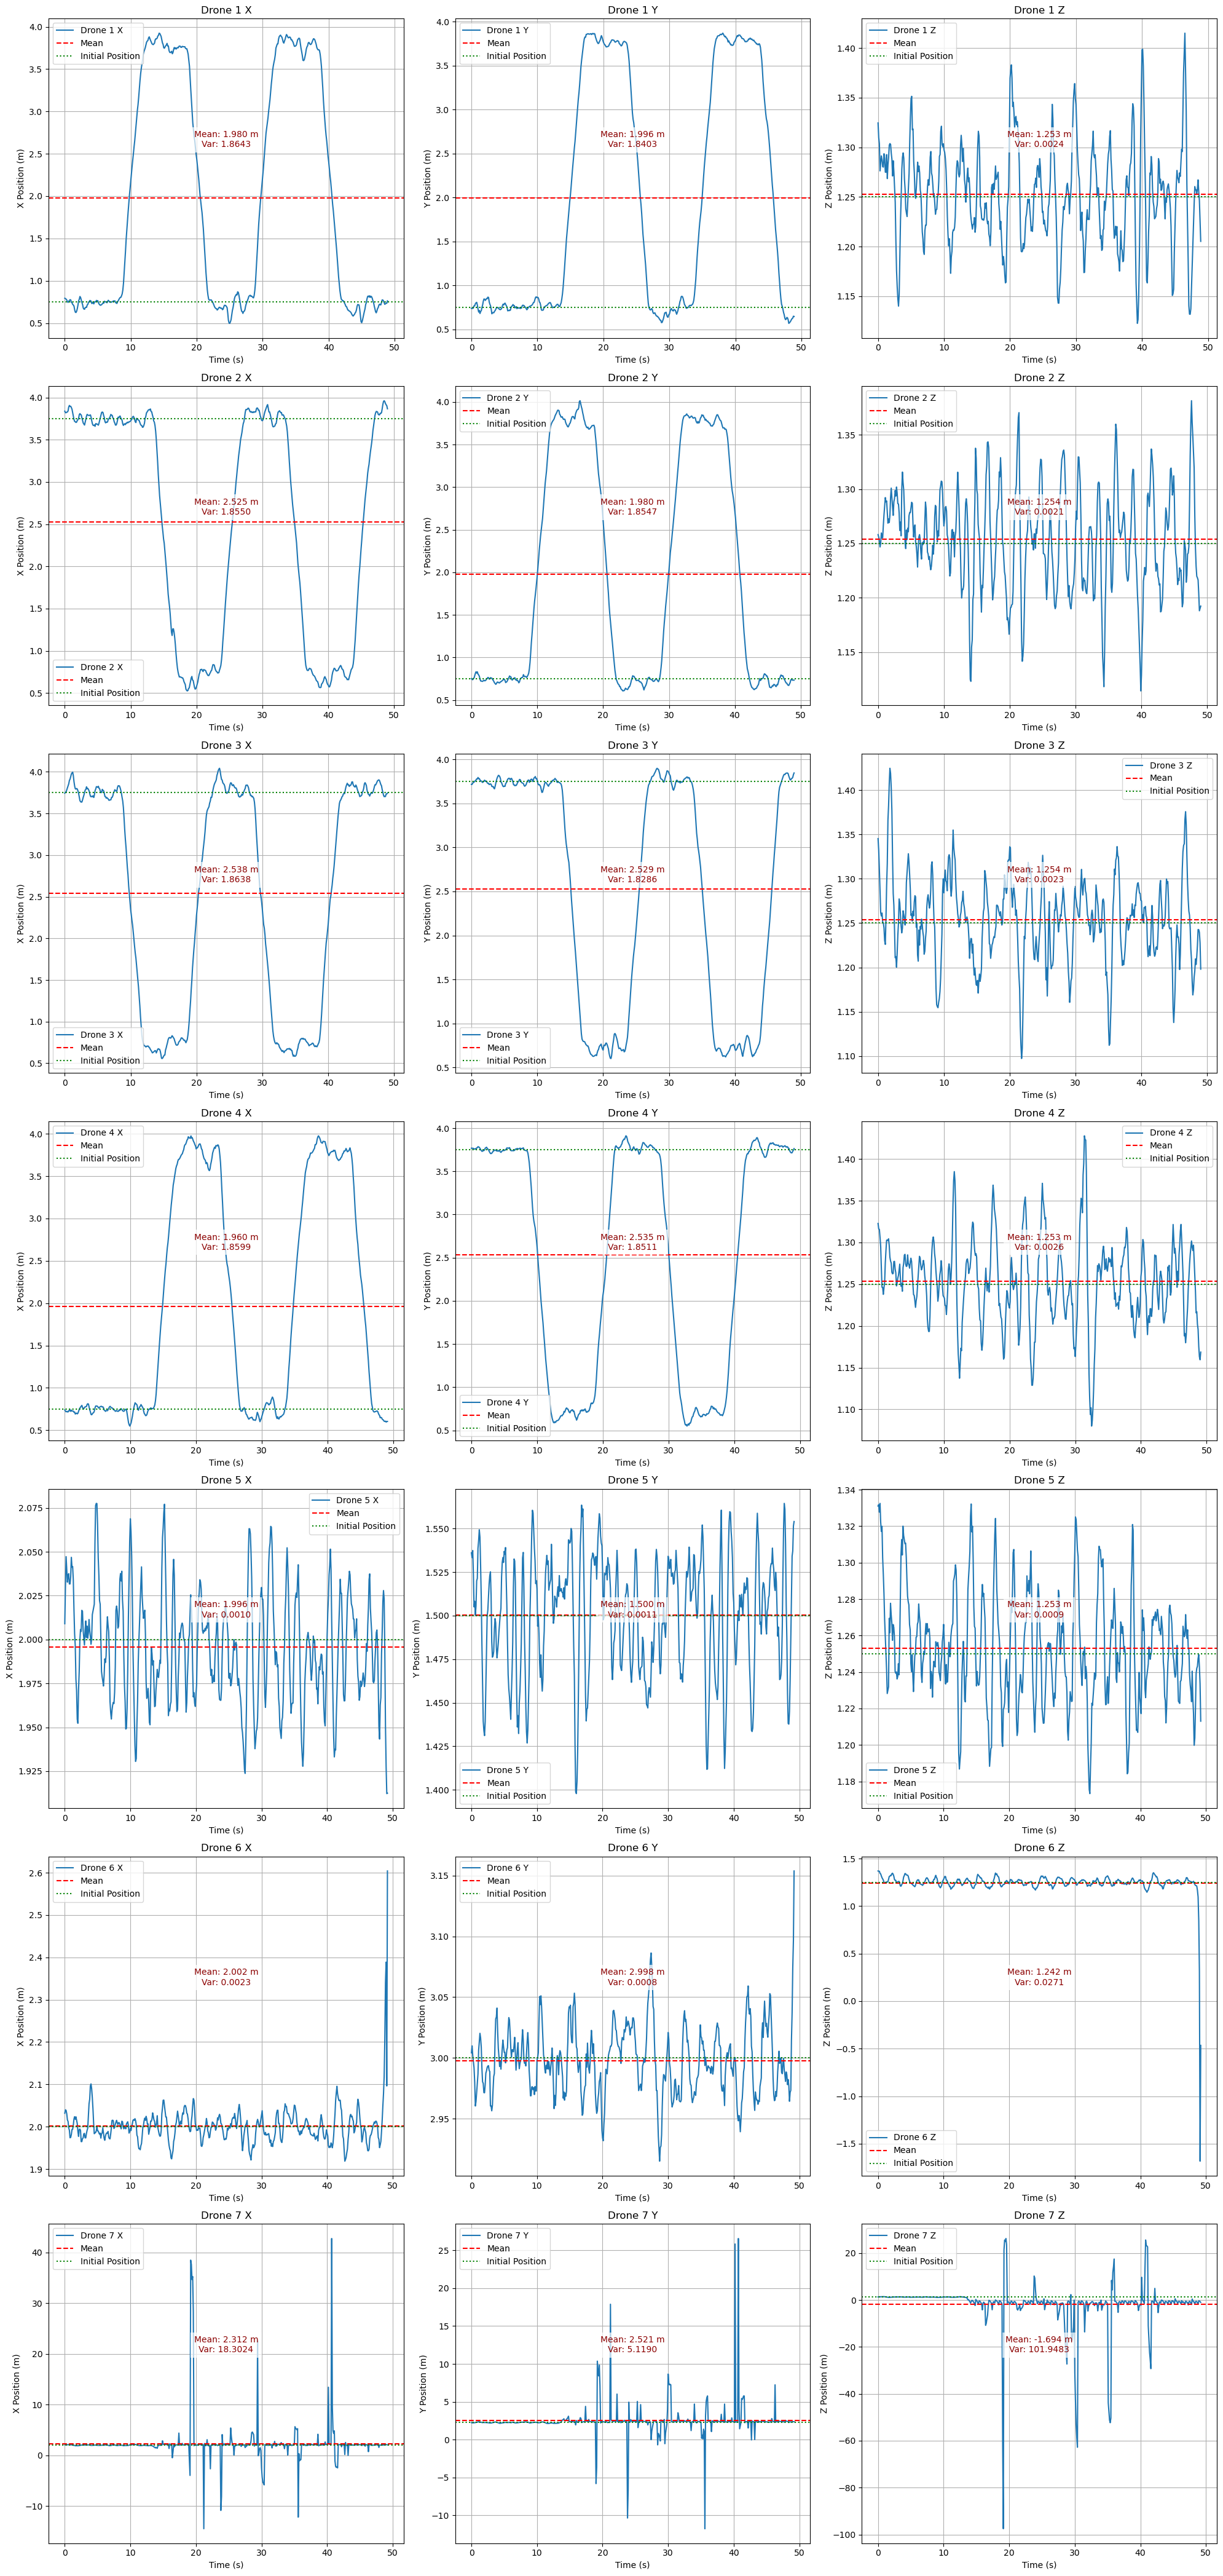

Figure saved as dataxyz_swarm_hlsquare_7


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # filename = 'C:/Users/omerr/drone_win/data_swarm/dataxyz_swarm.csv'

# if low_level:
#     figurename = f'dataxyz_swarm_llsquare_{len(uris)}'
#     gifname = 'dataxyz_swarm.gif'
# else:
#     figurename = f'dataxyz_swarm_hlsquare_{len(uris)}'
#     gifname = 'dataxyz_swarm.gif'

# # List of drone log files
# log_files = [f'C:/Users/omerr/drone-swarm/data_swarm/data_{uri[-2:]}.csv' for uri in uris]
# num_drones = len(log_files)
# coords = ['x', 'y', 'z']
# labels = ['X', 'Y', 'Z']

# fig, axes = plt.subplots(num_drones, 3, figsize=(20, 6 * num_drones), sharex=False)

# for idx, log_file in enumerate(log_files):
#     df = pd.read_csv(log_file, header=None, names=['timestamp', 'x', 'y', 'z'])
#     df['time_s'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 1000.0  # convert to seconds

#     # Exclude last 4 seconds
#     max_time = df['time_s'].max()
#     df_flight = df[df['time_s'] <= max_time - 4]

#     for j, coord in enumerate(coords):
#         ax = axes[idx, j] if num_drones > 1 else axes[j]
#         # Plot only flight data (excluding last 4 seconds)
#         ax.plot(df_flight['time_s'], df_flight[coord], label=f'Drone {idx+1} {labels[j]}')
#         mean_val = df_flight[coord].mean()
#         var_val = df_flight[coord].var()
#         ax.set_ylabel(f'{labels[j]} Position (m)')
#         ax.set_xlabel('Time (s)')
#         ax.set_title(f'Drone {idx+1} {labels[j]}')
#         ax.axhline(mean_val, color='red', linestyle='--', label='Mean')
#         ax.axhline(initial_pos[idx][j], color='green', linestyle=':', label='Initial Position')
#         ax.text(0.5, 0.65,
#             f'Mean: {mean_val:.3f} m\nVar: {var_val:.4f}',
#             transform=ax.transAxes,
#             fontsize=10,
#             color='darkred',
#             ha='center',
#             va='top',
#             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
#         )
#         ax.grid()
#         ax.legend()
        

# plt.tight_layout()
# plt.savefig(f'C:/Users/omerr/drone-swarm/data_swarm/{figurename}.png', dpi=300)
# plt.show()
# print(f"Figure saved as {figurename}")

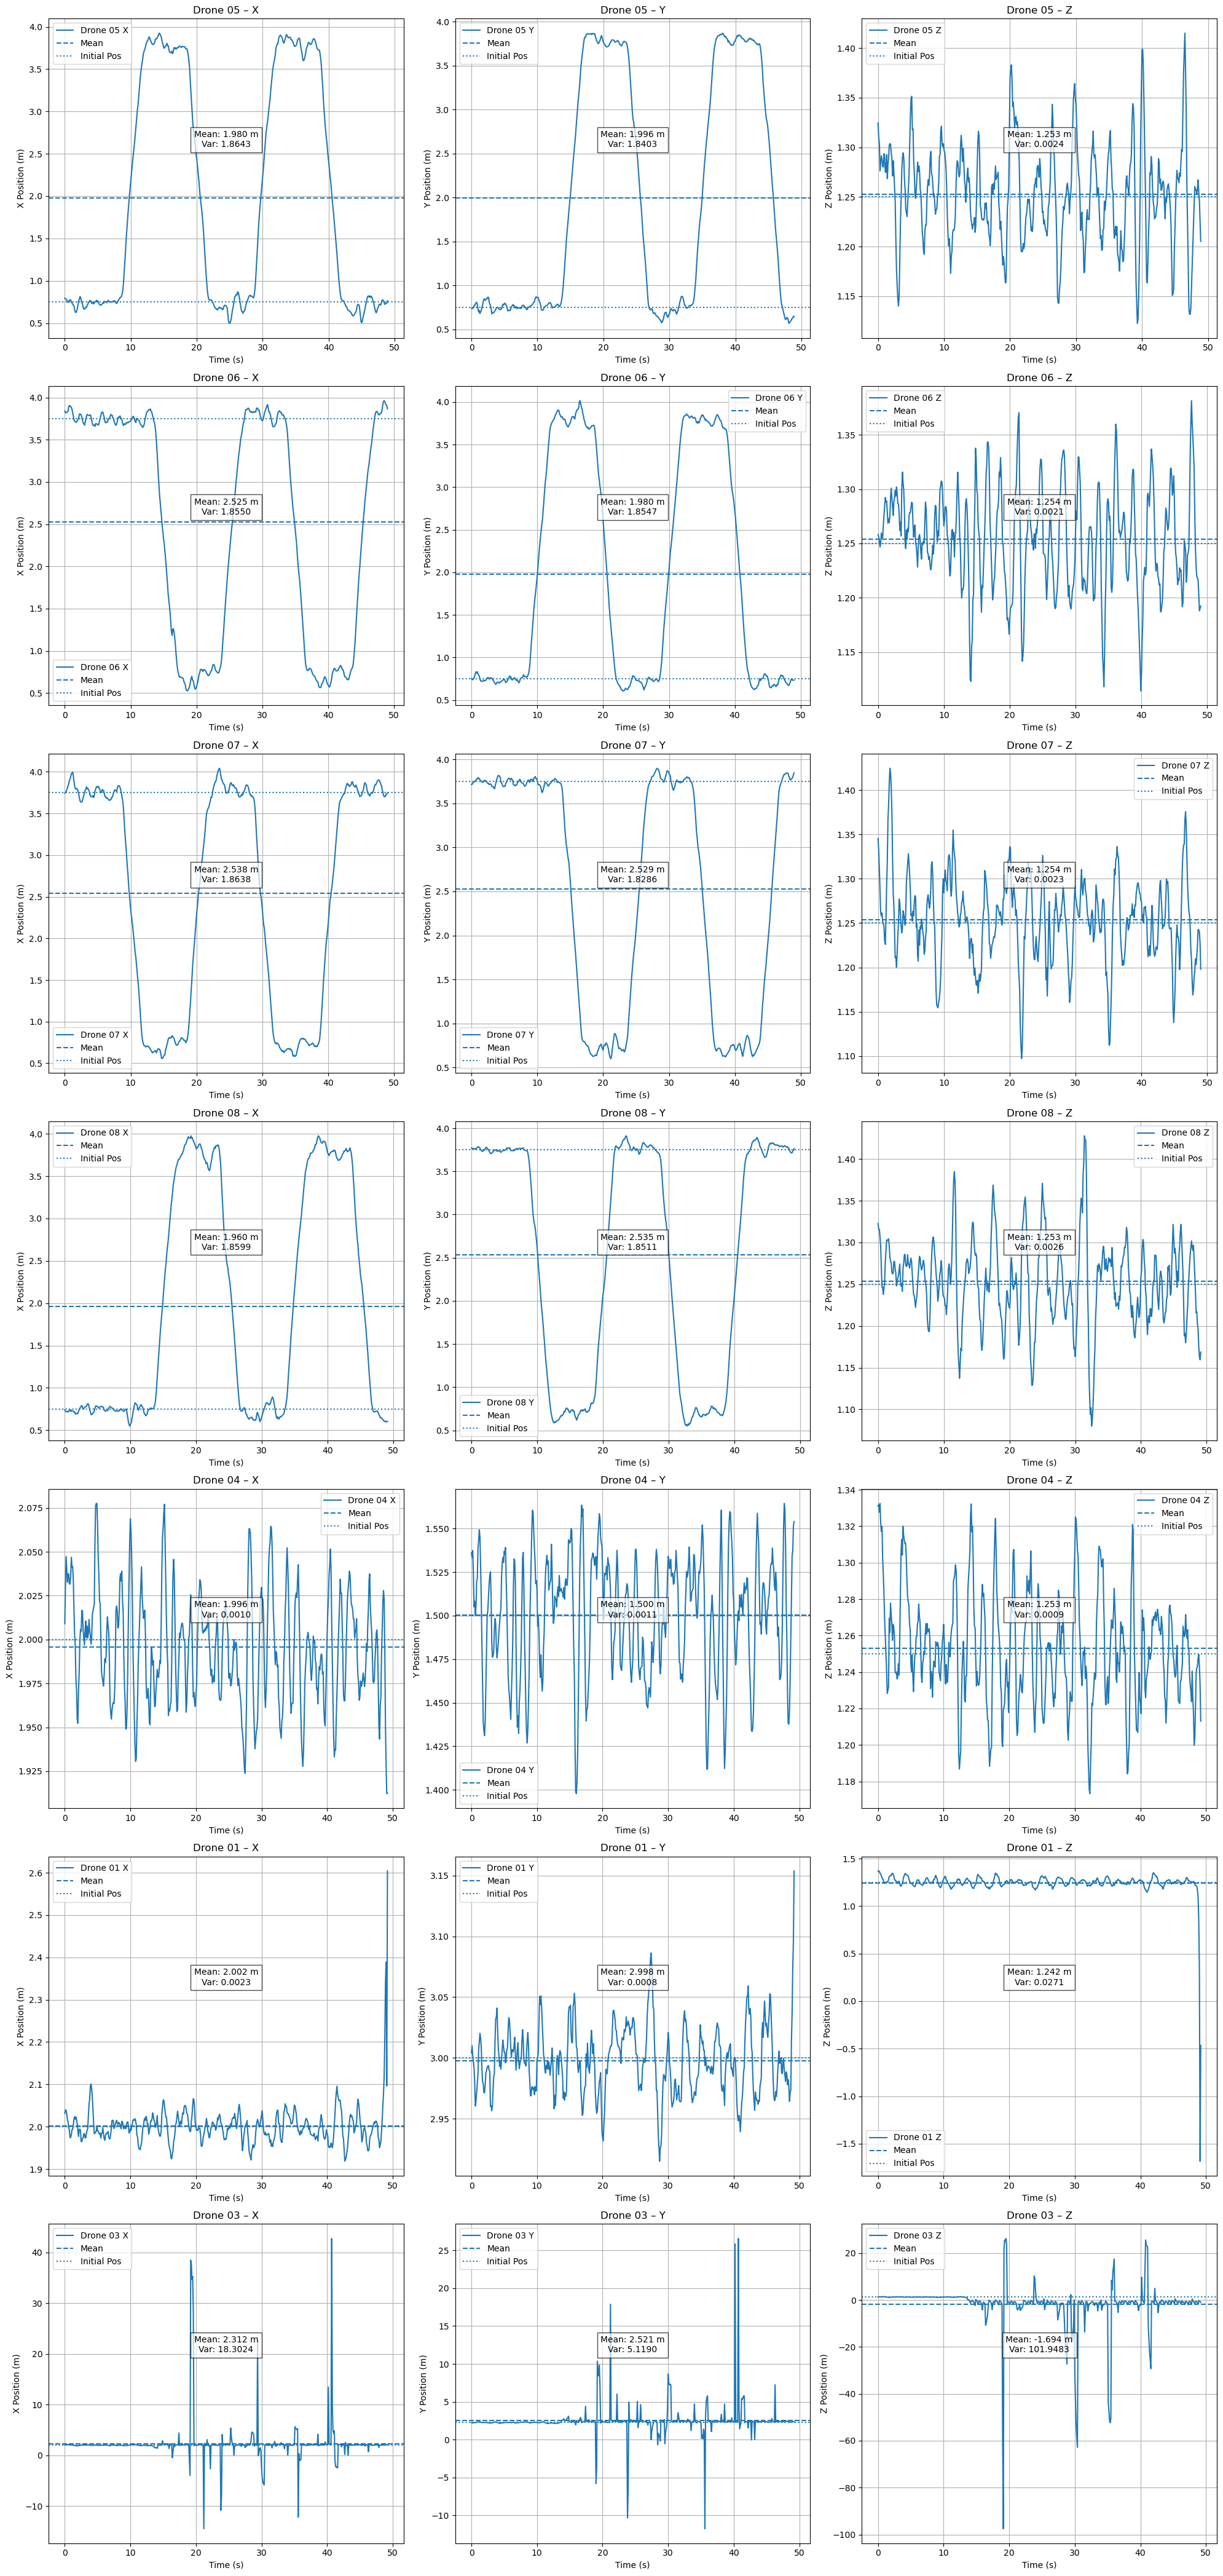

Figure saved as dataxyz_swarm_hlsquare_7


In [9]:
# Right after you define `log_files`, extract the two‑digit IDs:
drone_ids = [uri[-2:] for uri in uris]
fig, axes = plt.subplots(num_drones, 3, figsize=(20, 6 * num_drones), sharex=False)
# Later, in your plotting loop, iterate over both:
for idx, (log_file, drone_id) in enumerate(zip(log_files, drone_ids)):
    df = pd.read_csv(log_file, header=None, names=['timestamp', 'x', 'y', 'z'])
    df['time_s'] = (df['timestamp'] - df['timestamp'].iloc[0]) / 1000.0

    max_time = df['time_s'].max()
    df_flight = df[df['time_s'] <= max_time - 4]

    for j, coord in enumerate(coords):
        ax = axes[idx, j] if num_drones > 1 else axes[j]
        ax.plot(df_flight['time_s'], df_flight[coord],
                label=f'Drone {drone_id} {labels[j]}')

        mean_val = df_flight[coord].mean()
        var_val  = df_flight[coord].var()

        ax.set_ylabel(f'{labels[j]} Position (m)')
        ax.set_xlabel('Time (s)')
        ax.set_title(f'Drone {drone_id} – {labels[j]}')

        # Plot mean and initial-position lines
        ax.axhline(mean_val, linestyle='--', label='Mean')
        ax.axhline(initial_pos[idx][j], linestyle=':', label='Initial Pos')

        # Annotate stats
        ax.text(0.5, 0.65,
                f'Mean: {mean_val:.3f} m\nVar: {var_val:.4f}',
                transform=ax.transAxes,
                fontsize=10,
                ha='center',
                va='top',
                bbox=dict(facecolor='white', alpha=0.7))

        ax.grid()
        ax.legend()

plt.tight_layout()
plt.savefig(f'C:/Users/omerr/drone-swarm/data_swarm/{figurename}_corrlabel.png', dpi=300)
plt.show()
print(f"Figure saved as {figurename}")